In [1]:
import os
import random
import copy
import cv2
import numpy as np
import pandas as pd
import tqdm
import argparse
from PIL import Image
import matplotlib.pyplot as plt
from datetime import timedelta

# Pytorch Related Library
import torch
from torchvision import transforms
from torch.optim import lr_scheduler
import torch.distributed as dist

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM,FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image

random_state = 0

np.random.seed(random_state)
random.seed(random_state)
torch.manual_seed(random_state)

In [2]:
img_name = "1041220_21015_0_0.png"
class_index = 5
output_index = 0
thres = 0.5

# Creating a CAM heatmap

In [3]:
class SwinforRegression(torch.nn.Module):
    def __init__(self, model_name_or_path='microsoft/swin-large-patch4-window12-384-in22k', n_label=7):
        super().__init__()
        model = SwinForImageClassification.from_pretrained(model_name_or_path,num_labels=n_label,ignore_mismatched_sizes=True)
        self.swin = model.swin
        self.regressor_age = torch.nn.Linear(1536, 1)
        self.regressor_education = torch.nn.Linear(1536, 1)
        self.regressor_sleep = torch.nn.Linear(1536, 1)
        self.regressor_BMI = torch.nn.Linear(1536, 1)
        self.regressor_dbp = torch.nn.Linear(1536, 1)
        self.regressor_sbp = torch.nn.Linear(1536, 1)
        self.regressor_HbA1C = torch.nn.Linear(1536, 1)
        
    def forward(self, x):
        y_swin = self.swin(x).pooler_output
        y_age = self.regressor_age(y_swin)
        y_education = self.regressor_education(y_swin)
        y_sleep = self.regressor_sleep(y_swin)
        y_BMI = self.regressor_BMI(y_swin)
        y_dbp = self.regressor_dbp(y_swin)
        y_sbp = self.regressor_sbp(y_swin)
        y_HbA1C = self.regressor_HbA1C(y_swin)
    
        return y_age, y_education, y_sleep, y_BMI, y_dbp, y_sbp, y_HbA1C

In [4]:
class SingleOutputModel(torch.nn.Module):
    def __init__(self, model, output_index=0):
        super().__init__()
        self.model = model
        self.output_index = output_index

    def forward(self, x):
        return self.model(x)[self.output_index]

In [5]:
from transformers import ViTForImageClassification, SwinForImageClassification, AutoFeatureExtractor

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model = SwinforRegression(model_name_or_path='microsoft/swin-large-patch4-window12-384-in22k', n_label=7)
checkpoint = torch.load('/red/ruogu.fang/yyang/ADRiskFactorPrediction/swin/regression/savedmodel/Swin_regression/Swin_regression6loss0.13acc0.19.pth', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.to(device)

model_for_gradcam = SingleOutputModel(model, class_index)
model.eval()

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-large-patch4-window12-384-in22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 1536]) in the checkpoint and torch.Size([7, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SwinforRegression(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=192, out_features=192, bias=True)
                  (key): Linear(in_features=192, out_features=192, bias=True)
                  (value): Linear(in_features=192, out_features=192, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [6]:
class ClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        return model_output[self.category]

In [7]:
img = Image.open(os.path.join("/red/ruogu.fang/share/UKB/data/Eye/21015_fundus_left_1_good", img_name))
img = img.resize((576,576))
img = np.array(img)
img = img.astype(np.float32)
img = img/255
convert_tensor = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((576,576))
                                    ])
input_tensor = convert_tensor(img).to(device)

/blue/ruogu.fang/leem.s/conda/envs/monai-0.9.1/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
def reshape_transform(tensor, height=18, width=18):
    result = tensor[:, : , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

In [9]:
pred_ori = model(input_tensor.unsqueeze(0))

In [10]:
targets = [ClassifierOutputTarget(0)]
target_layers = [model_for_gradcam.model.swin.encoder.layers[-1].blocks[-1].layernorm_before]
#target_layers = [model_for_gradcam.model.swin.layernorm]

cam = ScoreCAM(model=model_for_gradcam, target_layers=target_layers, reshape_transform=reshape_transform)

pred = model_for_gradcam(input_tensor.unsqueeze(0))
output = cam(input_tensor=input_tensor.unsqueeze(0), targets=targets, aug_smooth = True, eigen_smooth=False)

100%|██████████| 96/96 [00:56<00:00,  1.69it/s]


In [11]:
cam = output[0, :]

(576, 576)


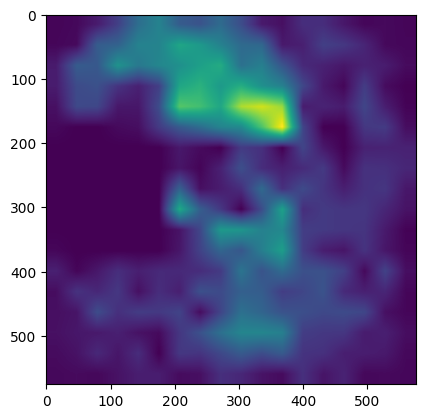

In [12]:
print(np.shape(cam))
plt.imshow(cam)

In [13]:
th, im_th = cv2.threshold(cam, thres, 1.0, cv2.THRESH_BINARY)

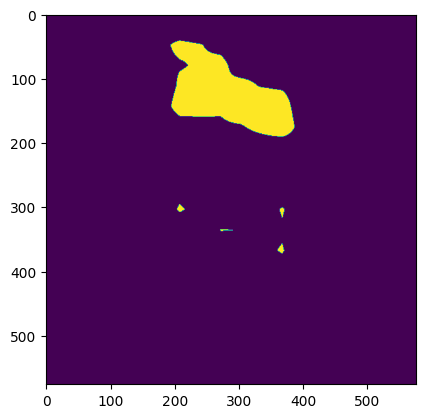

In [14]:
plt.imshow(im_th)

# Reading the Artery & Vein segmentation results & processing it

In [15]:
img_seg_artery = Image.open(os.path.join("/red/ruogu.fang/leem.s/NSF-SCH/code/data/regression_segmentation/M2/artery_vein/artery_binary_process", img_name))
img_seg_vein = Image.open(os.path.join("/red/ruogu.fang/leem.s/NSF-SCH/code/data/regression_segmentation/M2/artery_vein/vein_binary_process", img_name))

In [16]:
img_seg_artery = img_seg_artery.resize((576,576))
img_seg_artery  = np.array(img_seg_artery)
th, img_seg_artery = cv2.threshold(img_seg_artery, 0.1, 1.0, cv2.THRESH_BINARY)
img_seg_artery = img_seg_artery.astype(np.float32)

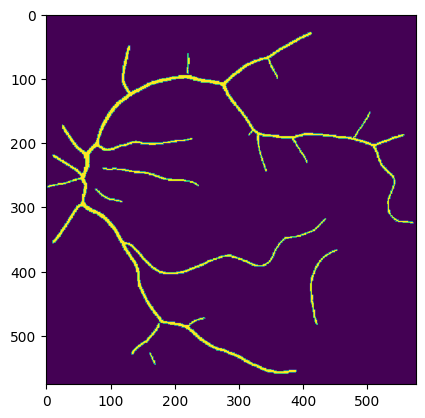

In [17]:
plt.imshow(img_seg_artery)

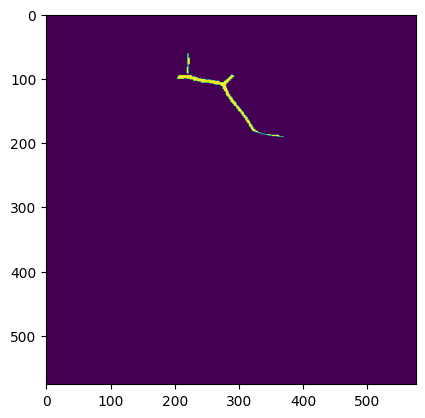

In [18]:
overlay_artery = img_seg_artery * im_th
plt.imshow(overlay_artery)
im = Image.fromarray(overlay_artery*255).convert('RGB')
im.save(img_name[:-4] + '_'+"Artery"+".jpeg")

In [19]:
print("The percentage of artery used for the inference is {:.2f}%".format(np.count_nonzero(overlay_artery)/np.count_nonzero(img_seg_artery)*100))

The percentage of artery used for the inference is 9.10%


In [20]:
img_seg_vein = img_seg_vein.resize((576,576))
img_seg_vein  = np.array(img_seg_vein)
th, img_seg_vein = cv2.threshold(img_seg_vein, 0.1, 1.0, cv2.THRESH_BINARY)
img_seg_vein = img_seg_vein.astype(np.float32)

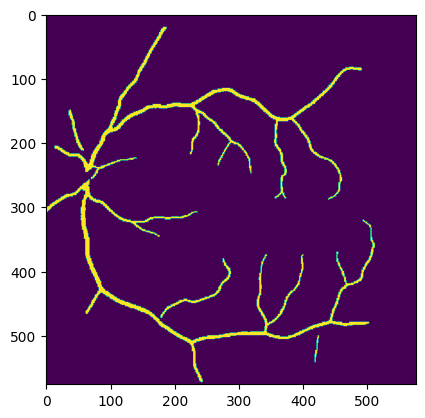

In [21]:
plt.imshow(img_seg_vein)

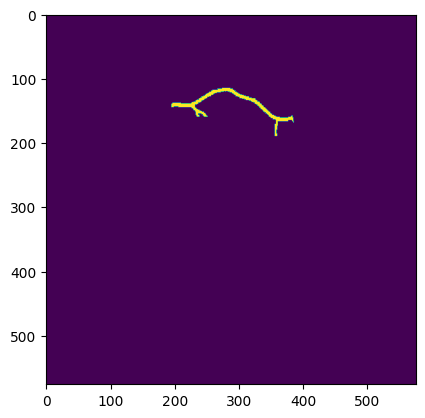

In [22]:
overlay_vein = img_seg_vein * im_th
plt.imshow(overlay_vein)
im = Image.fromarray(overlay_vein*255).convert('RGB')
im.save(img_name[:-4] +"_"+"Vein"+".jpeg")

In [23]:
print("The percentage of vein used for the inference is {:.2f}%".format(np.count_nonzero(overlay_vein)/np.count_nonzero(img_seg_vein)*100))

The percentage of vein used for the inference is 10.00%


## Reading the optic cup and disc & processing it

In [24]:
img_seg_optic_disc_cup = Image.open(os.path.join("/red/ruogu.fang/leem.s/NSF-SCH/code/data/regression_segmentation/M2/optic_disc_cup/raw", img_name))

In [25]:
img_seg_optic_disc_cup = img_seg_optic_disc_cup.resize((576,576))
img_seg_optic_disc_cup  = np.array(img_seg_optic_disc_cup)
img_seg_optic_disc_cup = img_seg_optic_disc_cup.astype(np.float32)
img_seg_optic_disc_cup = img_seg_optic_disc_cup/255
#th, img_seg_vessels = cv2.threshold(img_seg_vessels, 0.1, 1.0, cv2.THRESH_BINARY)
img_seg_optic_disc_cup = img_seg_optic_disc_cup.astype(np.float32)

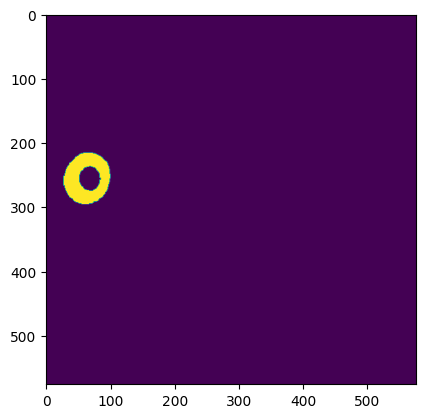

In [26]:
img_seg_optic_disc = img_seg_optic_disc_cup[:, :, 0]
#img_seg_optic_disc[350:550, 50:250]=0
plt.imshow(img_seg_optic_disc)

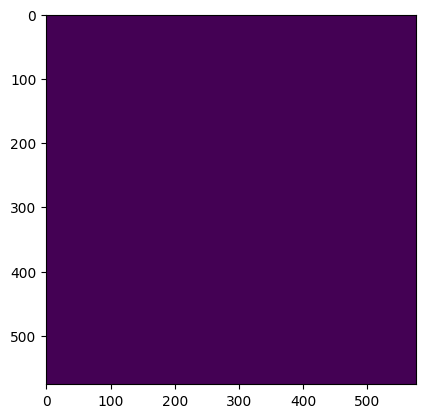

In [27]:
overlay_optic_disc = img_seg_optic_disc * im_th
plt.imshow(overlay_optic_disc)
im = Image.fromarray(overlay_optic_disc*255).convert('RGB')
im.save(img_name[:-4] +"_"+"Disc"+".jpeg")

In [28]:
print("The percentage of disc used for the inference is {:.2f}%".format(np.count_nonzero(overlay_optic_disc)/np.count_nonzero(img_seg_optic_disc)*100))

The percentage of disc used for the inference is 0.00%


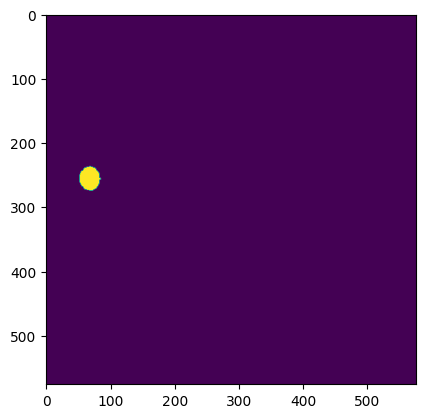

In [29]:
img_seg_optic_cup = img_seg_optic_disc_cup[:, :, 2]
#img_seg_optic_cup[350:550, 50:250]=0
plt.imshow(img_seg_optic_cup)

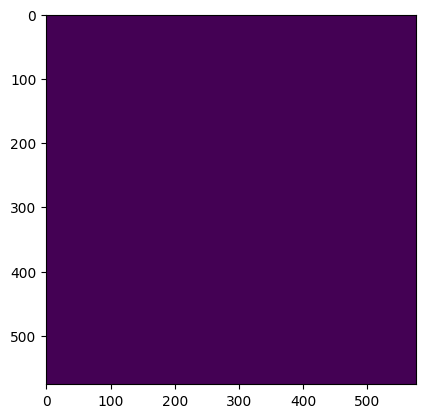

In [30]:
overlay_optic_cup = img_seg_optic_cup * im_th
plt.imshow(overlay_optic_cup)
im = Image.fromarray(overlay_optic_cup*255).convert('RGB')
im.save(img_name[:-4] +"_"+"Cup"+".jpeg")

In [31]:
print("The percentage of cup used for the inference is {:.2f}%".format(np.count_nonzero(overlay_optic_cup)/np.count_nonzero(img_seg_optic_cup)*100))

The percentage of cup used for the inference is 0.00%
